Adapted from MONAI tutorial:<br>
https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb<br>

In [ ]:
# Install libraries.
"""!conda install -c conda-forge tqdm -y
!conda install -c conda-forge tensorboard -y
!pip uninstall monai -y
!pip install tensorboard
!pip install 'monai[all]'
!python -c "import matplotlib" || pip install -q matplotlib
!python -c 'import monai; monai.config.print_config()'
%matplotlib inline"""

In [1]:
from IPython.display import clear_output

In [5]:
import numpy as np
import glob
import os
import tqdm
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import random
import math
from skimage import metrics

random.seed(42)

In [6]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch.nn import BCELoss, BCEWithLogitsLoss, CrossEntropyLoss
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [7]:
import monai
from monai.networks.layers import Norm
from monai.data import create_test_image_2d, list_data_collate, decollate_batch
from monai.visualize import plot_2d_or_3d_image

from monai.utils import first, set_determinism
from monai.transforms import (
    Activations,
    AddChanneld,
    AsDiscrete,
    EnsureChannelFirstd,
    EnsureType,
    CenterSpatialCropd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandAffined,
    RandCropByPosNegLabeld,
    RemoveSmallObjects,
    ScaleIntensityd,
    EnsureTyped,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
set_determinism(seed=42) 

In [8]:
# Set directories.

root_dir = '/home/charissa/minivess/data'

images = glob.glob('/home/charissa/minivess/0publish/raw/'+'*.nii.gz')
labels = glob.glob('/home/charissa/minivess/0publish/seg/'+'*.nii.gz')

images = sorted(images)
labels = sorted(labels)

data_dicts = [
    {'image': image_name, 'label': label_name}
    for image_name, label_name in zip(images, labels)
]

# Split data for training and testing.
random.Random(42).shuffle(data_dicts)
split_train = int(len(images)*.8)
split_val_test = int(len(images)*.1)
assert(split_train+split_val_test*2 == len(images))

train_files = data_dicts[:split_train]
val_files = data_dicts[split_train:split_train+split_val_test]
test_files = data_dicts[split_train+split_val_test:]

print('{} train_files, {} val_files, {} test_files'.format(len(train_files), len(val_files), len(test_files)))
assert((len(train_files)+len(test_files)+len(val_files)) == len(images))

56 train_files, 7 val_files, 7 test_files


In [9]:
daten = input('Input date, which will be used to save relevant plots/images for this run: (yyyymmdd):')
best_model_name = daten +'_best_metric_model.pth'
print(best_model_name)

Input date, which will be used to save relevant plots/images for this run: (yyyymmdd): 20230127


20230127_best_metric_model.pth


In [11]:
# Set transforms for training, validation, and saving validation outputs (train_transform2).
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=['image', 'label'], minv=0.0, maxv=1.0),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size= (96,96,1), #(160, 160),
            pos=3,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
          RandAffined(
             keys=['image', 'label'],
             mode=('bilinear', 'nearest'),
             prob=1.0, spatial_size=(96,96,1),
             rotate_range=(0, 0, np.pi/15),
             scale_range=(0.1, 0.1)),
        EnsureTyped(keys=["image", "label"], data_type='tensor'),
    ]
)


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=['image', 'label'], minv=0.0, maxv=1.0),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[-1,-1,1]),
        EnsureTyped(keys=["image", "label"], data_type='tensor'),
    ]
)

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityd(keys=['image', 'label'], minv=0.0, maxv=1.0),
        CenterSpatialCropd(keys=["image", "label"], roi_size=[-1,-1,1]),
        EnsureTyped(keys=["image", "label"], data_type='tensor'),
    ]
)

image shape: torch.Size([4, 1, 96, 96, 1]), label shape: torch.Size([4, 1, 96, 96, 1])
label values: [0 1]
image max: 0.4471955895423889, image min: 0.006625339854508638


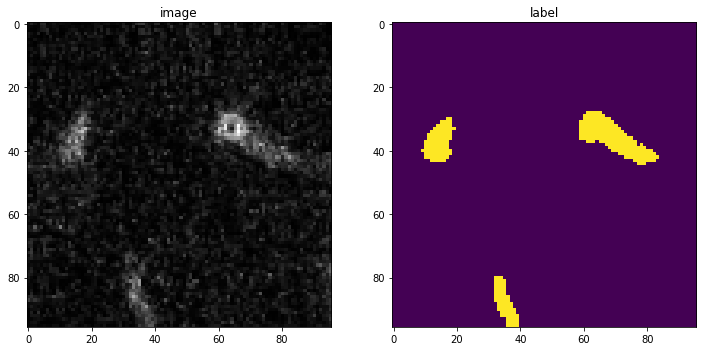

torch.Size([4, 1, 96, 96, 1])


In [13]:
# See example of image, label.
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"], check_data["label"])
label = label.int()
print(f"image shape: {image.shape}, label shape: {label.shape}")
print(f'label values: {np.unique(label)}')
print(f'image max: {image.max()}, image min: {image.min()}')
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0,0,...], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0,0,...])
plt.show()

print(image.shape)

In [14]:
# Create Datasets and DataLoaders.

# Dataset and DataLoader for training.
train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(
    train_ds,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=list_data_collate,
    pin_memory=torch.cuda.is_available(),
)

# Dataset and DataLoader for validation.
val_ds = monai.data.Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)

# Dataset and DataLoader for testing.
test_ds = monai.data.Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, collate_fn=list_data_collate)


# Metrics.
dice_metric = DiceMetric(include_background=False, reduction="mean", get_not_nans=False)

In [15]:
# Create UNet, DiceLoss and Adam optimizer.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)

model = monai.networks.nets.UNet(
    dimensions=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

device: cuda:0


monai.networks.nets.unet UNet.__init__:dimensions: Argument `dimensions` has been deprecated since version 0.6. Please use `spatial_dims` instead.


In [ ]:
# Typical PyTorch training loop.

epochs = 200
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()

for epoch in range(epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["image"].to(device), batch_data["label"].to(device)
        inputs = inputs[...,0]
        labels = labels[...,0]
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        #print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            val_images = None
            val_labels = None
            val_outputs = None
            for val_data in val_loader:
                val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
                val_images = val_images[...,0]
                val_labels = val_labels[...,0]
                roi_size = (96, 96)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                # Compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
            # Aggregate the final mean dice resul
            metric = dice_metric.aggregate().item()
            # Reset the status for next validation round
            dice_metric.reset()
            
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), best_model_name)
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")


In [ ]:
# Plot loss and mean Dice.
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(daten + best_model_name[:-4] + '_diceloss.jpg')
plt.show()

In [ ]:
# Write epoch loss values and dice values to file.
export_prefix = daten + '_unet'
export_diceloss = export_prefix + '_diceloss.txt'
export_dicemetric = export_prefix + '_dicemetric.txt'

with open(export_diceloss, 'a') as myfile1:
    myfile1.write('\n'.join(str(item) for item in epoch_loss_values)+'\n')
with open(export_dicemetric, 'a') as myfile2:
    myfile2.write('\n'.join(str(item) for item in metric_values)+'\n')

In [ ]:
# testing
best_model_name = '/home/charissa/minivess/code/20230120_best_metric_model.pth'
post_trans = Compose([EnsureType(data_type='tensor'), AsDiscrete(threshold=0.6)]) 
model.load_state_dict(torch.load(best_model_name))
test_dice=0
test_hausdorff=0

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data["image"].to(device), test_data["label"].to(device)
        test_images = test_images[...,0]
        test_labels = test_labels[...,0]
        
        # define sliding window size and batch size for windows inference
        roi_size = (96, 96)
        sw_batch_size = 4

        test_outputs = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
        test_outputs = post_trans(test_outputs)
        test_labels = decollate_batch(test_labels)
        
        # compute metric for current iteration
        dice_metric(y_pred=test_outputs[0], y=test_labels[0])       
        
        # visualize outputs
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image")
        plt.imshow(test_data["image"][0, 0, :, :], cmap="gray")
        #print('val_data-image:' ,np.unique(val_data["image"][0, 0, :, :]))
        plt.subplot(1, 3, 2)
        plt.title(f"label")
        plt.imshow(test_data["label"][0, 0, :, :], cmap='gray')
        print('test_data-label:' ,np.unique(test_data["label"][0, 0, :, :]))
        plt.subplot(1, 3, 3)
        plt.title(f"output")
        plt.imshow(test_outputs[0].detach().cpu()[0, :, :], cmap='gray')
        print('test_outputs shape:', test_outputs[0].shape, test_outputs[0].dtype)
        #print('test_outputs:', np.unique(test_outputs[0].detach().cpu()))
        plt.show()
        clear_output(wait=True)
        
        if False:
            for test_output in test_outputs:
                saver(test_output)
                
                
    # aggregate the final mean dice result
    test_dice += dice_metric.aggregate().item()
    
        
    
    # reset the status
    dice_metric.reset()
    
    print("evaluation metric:", test_dice)
